In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', 'plates', '__notebook__.ipynb']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
data_root = '/data/Projects/kaggle/plates_class/plates/'

In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 812.86it/s]


In [5]:
!ls train

cleaned  dirty


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.CenterCrop(220),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(5, 34)

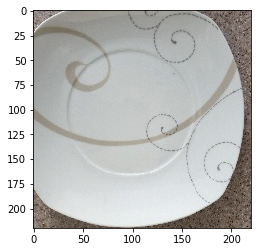

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
accuracy = {'train': [], 'val': []}
losses = {'train': [], 'val': []}
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.data.cpu()
                running_acc += (preds_class == labels.data).float().mean().data.cpu()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            accuracy[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, accuracy, losses

In [11]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.95, weight_decay=0.00001)
# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3, weight_decay=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
_, accuracies, losses = train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:00<00:00,  6.33it/s]

train Loss: 0.7851 Acc: 0.4500



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.7127 Acc: 0.6667
Epoch 1/99:



100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

train Loss: 0.9975 Acc: 0.4750



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.6039 Acc: 0.6667
Epoch 2/99:



100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

train Loss: 0.6257 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

val Loss: 0.9273 Acc: 0.5000
Epoch 3/99:



100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

train Loss: 0.6663 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.5046 Acc: 0.6667
Epoch 4/99:



100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

train Loss: 0.4988 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.5472 Acc: 0.8333
Epoch 5/99:



100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

train Loss: 0.4063 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.4762 Acc: 0.6667
Epoch 6/99:



100%|██████████| 5/5 [00:00<00:00,  6.13it/s]

train Loss: 0.3562 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.6123 Acc: 0.8333
Epoch 7/99:



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

train Loss: 0.3722 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5400 Acc: 0.6667
Epoch 8/99:



100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

train Loss: 0.3192 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

val Loss: 0.5712 Acc: 0.6667
Epoch 9/99:



100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

train Loss: 0.1696 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5614 Acc: 0.6667
Epoch 10/99:



100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

train Loss: 0.3399 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.5591 Acc: 0.6667
Epoch 11/99:



100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

train Loss: 0.2528 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.6503 Acc: 0.6667
Epoch 12/99:



100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

train Loss: 0.2412 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.6531 Acc: 0.6667
Epoch 13/99:



100%|██████████| 5/5 [00:00<00:00,  6.20it/s]

train Loss: 0.2696 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

val Loss: 0.5884 Acc: 0.6667
Epoch 14/99:



100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

train Loss: 0.1473 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.5658 Acc: 0.6667
Epoch 15/99:



100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

train Loss: 0.1590 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.5699 Acc: 0.6667
Epoch 16/99:



100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

train Loss: 0.3340 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

val Loss: 0.5953 Acc: 0.6667
Epoch 17/99:



100%|██████████| 5/5 [00:00<00:00,  5.12it/s]

train Loss: 0.1597 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.5971 Acc: 0.6667
Epoch 18/99:



100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

train Loss: 0.2937 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.6328 Acc: 0.6667
Epoch 19/99:



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

train Loss: 0.1714 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.6571 Acc: 0.6667
Epoch 20/99:



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

train Loss: 0.2980 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.5948 Acc: 0.6667
Epoch 21/99:



100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

train Loss: 0.1216 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

val Loss: 0.5773 Acc: 0.6667
Epoch 22/99:



100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

train Loss: 0.1197 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.5724 Acc: 0.6667
Epoch 23/99:



100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

train Loss: 0.3400 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.6022 Acc: 0.6667
Epoch 24/99:



100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

train Loss: 0.3696 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.5826 Acc: 0.6667
Epoch 25/99:



100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

train Loss: 0.1485 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.5787 Acc: 0.6667
Epoch 26/99:



100%|██████████| 5/5 [00:00<00:00,  6.58it/s]

train Loss: 0.2773 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.5692 Acc: 0.6667
Epoch 27/99:



100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

train Loss: 0.3078 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.6091 Acc: 0.6667
Epoch 28/99:



100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

train Loss: 0.3257 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.5968 Acc: 0.6667
Epoch 29/99:



100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

train Loss: 0.3991 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.6173 Acc: 0.6667
Epoch 30/99:



100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

train Loss: 0.2957 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6039 Acc: 0.6667
Epoch 31/99:



100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

train Loss: 0.1975 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

val Loss: 0.6077 Acc: 0.6667
Epoch 32/99:



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

train Loss: 0.2059 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.6341 Acc: 0.6667
Epoch 33/99:



100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

train Loss: 0.1166 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 0.6098 Acc: 0.6667
Epoch 34/99:



100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

train Loss: 0.3366 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5433 Acc: 0.6667
Epoch 35/99:



100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

train Loss: 0.2595 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

val Loss: 0.5662 Acc: 0.6667
Epoch 36/99:



100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

train Loss: 0.1784 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.6108 Acc: 0.6667
Epoch 37/99:



100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

train Loss: 0.2823 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.6187 Acc: 0.6667
Epoch 38/99:



100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

train Loss: 0.3183 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

val Loss: 0.6026 Acc: 0.6667
Epoch 39/99:



100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

train Loss: 0.1993 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.6420 Acc: 0.6667
Epoch 40/99:



100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

train Loss: 0.2657 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.5843 Acc: 0.6667
Epoch 41/99:



100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

train Loss: 0.2513 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

val Loss: 0.5971 Acc: 0.6667
Epoch 42/99:



100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

train Loss: 0.3073 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.6344 Acc: 0.6667
Epoch 43/99:



100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

train Loss: 0.3564 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

val Loss: 0.6012 Acc: 0.6667
Epoch 44/99:



100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

train Loss: 0.3371 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

val Loss: 0.5968 Acc: 0.6667
Epoch 45/99:



100%|██████████| 5/5 [00:00<00:00,  5.39it/s]

train Loss: 0.4293 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.6323 Acc: 0.6667
Epoch 46/99:



100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

train Loss: 0.2675 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.5911 Acc: 0.6667
Epoch 47/99:



100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

train Loss: 0.1588 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

val Loss: 0.5891 Acc: 0.6667
Epoch 48/99:



100%|██████████| 5/5 [00:00<00:00,  5.66it/s]

train Loss: 0.3318 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

val Loss: 0.6258 Acc: 0.6667
Epoch 49/99:



100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

train Loss: 0.2433 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.5874 Acc: 0.6667
Epoch 50/99:



100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

train Loss: 0.1586 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

val Loss: 0.5638 Acc: 0.6667
Epoch 51/99:



100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

train Loss: 0.1969 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.5583 Acc: 0.6667
Epoch 52/99:



100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

train Loss: 0.1927 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.5911 Acc: 0.6667
Epoch 53/99:



100%|██████████| 5/5 [00:01<00:00,  4.32it/s]

train Loss: 0.1702 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.5993 Acc: 0.6667
Epoch 54/99:



100%|██████████| 5/5 [00:01<00:00,  4.99it/s]

train Loss: 0.2838 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.5906 Acc: 0.6667
Epoch 55/99:



100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

train Loss: 0.3038 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

val Loss: 0.6162 Acc: 0.6667
Epoch 56/99:



100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

train Loss: 0.2190 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.6493 Acc: 0.6667
Epoch 57/99:



100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

train Loss: 0.2744 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.5947 Acc: 0.6667
Epoch 58/99:



100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

train Loss: 0.2084 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.6032 Acc: 0.6667
Epoch 59/99:



100%|██████████| 5/5 [00:00<00:00,  5.03it/s]

train Loss: 0.2194 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.6333 Acc: 0.6667
Epoch 60/99:



100%|██████████| 5/5 [00:00<00:00,  5.09it/s]

train Loss: 0.1571 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.6454 Acc: 0.6667
Epoch 61/99:



100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

train Loss: 0.3790 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.6227 Acc: 0.6667
Epoch 62/99:



100%|██████████| 5/5 [00:00<00:00,  5.84it/s]

train Loss: 0.4539 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

val Loss: 0.6014 Acc: 0.6667
Epoch 63/99:



100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

train Loss: 0.2888 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.6409 Acc: 0.6667
Epoch 64/99:



100%|██████████| 5/5 [00:00<00:00,  6.28it/s]

train Loss: 0.2094 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.6424 Acc: 0.6667
Epoch 65/99:



100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

train Loss: 0.3304 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

val Loss: 0.6515 Acc: 0.6667
Epoch 66/99:



100%|██████████| 5/5 [00:00<00:00,  5.10it/s]

train Loss: 0.3028 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.6187 Acc: 0.6667
Epoch 67/99:



100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

train Loss: 0.1619 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

val Loss: 0.5613 Acc: 0.6667
Epoch 68/99:



100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

train Loss: 0.4158 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

val Loss: 0.5403 Acc: 0.6667
Epoch 69/99:



100%|██████████| 5/5 [00:00<00:00,  6.13it/s]

train Loss: 0.2968 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

val Loss: 0.5534 Acc: 0.6667
Epoch 70/99:



100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

train Loss: 0.2940 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 0.5550 Acc: 0.6667
Epoch 71/99:



100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

train Loss: 0.3681 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

val Loss: 0.5435 Acc: 0.6667
Epoch 72/99:



100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

train Loss: 0.1508 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 0.5582 Acc: 0.6667
Epoch 73/99:



100%|██████████| 5/5 [00:00<00:00,  5.97it/s]

train Loss: 0.2283 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5737 Acc: 0.6667
Epoch 74/99:



100%|██████████| 5/5 [00:00<00:00,  6.36it/s]

train Loss: 0.2185 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.5906 Acc: 0.6667
Epoch 75/99:



100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

train Loss: 0.3305 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.5789 Acc: 0.6667
Epoch 76/99:



100%|██████████| 5/5 [00:00<00:00,  6.22it/s]

train Loss: 0.1663 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

val Loss: 0.6132 Acc: 0.6667
Epoch 77/99:



100%|██████████| 5/5 [00:00<00:00,  5.68it/s]

train Loss: 0.1616 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

val Loss: 0.6099 Acc: 0.6667
Epoch 78/99:



100%|██████████| 5/5 [00:00<00:00,  6.09it/s]

train Loss: 0.3312 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.6318 Acc: 0.6667
Epoch 79/99:



100%|██████████| 5/5 [00:00<00:00,  5.70it/s]

train Loss: 0.2233 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

val Loss: 0.6226 Acc: 0.6667
Epoch 80/99:



 80%|████████  | 4/5 [00:00<00:00,  5.23it/s]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13.0, 7.0)

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.title('Accuracy');

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.title('Loss');

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [132]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [133]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=10)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [134]:
import time

In [135]:
submission_df.to_csv('submission_' + str(time.time()/1e-6) + '.csv')

In [136]:
!rm -rf train val test